# 01. Import Libraries

In [1]:
pip install nasdaq-data-link

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

from pylab import rcParams
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

# 02. Import Data

In [3]:
path = r'C:\Users\esteb\OneDrive\Desktop\2025_Credit Card Transaction Analysis'

In [4]:
df = pd.read_pickle(os.path.join(path, '02_Data', 'Prepared Data', 'cc_combined_transactions.pkl'))

# 03. Wrangle Data

In [5]:
df.columns

Index(['user_id', 'card_index', 'txn_year', 'txn_month', 'txn_day', 'txn_date',
       'txn_time', 'txn_amount', 'txn_flag', 'txn_type', 'merchant_name',
       'merchant_city', 'merchant_state', 'merchant_country', 'txn_zip_code',
       'MCC', 'errors?', 'is_fraud?', 'Amount Category', 'user_name',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'apartment', 'city', 'state', 'user_zip_code', 'latitude',
       'longitude', 'per_capita_income_zip_code', 'yearly_income_person',
       'total_debt', 'FICO_score', 'num_credit_cards', 'Income_category',
       'card_brand', 'card_type', 'card_number', 'expires', 'CVV', 'has_chip',
       'cards_issued', 'credit_limit', 'acct_open_date',
       'year_PIN_last_changed', 'card_on_dark_web', 'Credit Limit Category',
       'Age Group', 'Income Bracket'],
      dtype='object')

In [6]:
df['txn_date'].head()

0   2002-09-01
1   2002-09-01
2   2002-09-02
3   2002-09-02
4   2002-09-03
Name: txn_date, dtype: datetime64[ns]

In [7]:
df['txn_amount'].head()

0    134.09
1     38.48
2    120.34
3    128.95
4    104.71
Name: txn_amount, dtype: float64

In [8]:
df['card_type'].unique()

array(['Debit', 'Credit', 'Debit (Prepaid)'], dtype=object)

In [9]:
# Keep only positive transactions made with credit cards

df_credit = df[(df['txn_amount'] > 0) & (df['card_type'] =='Credit')]

In [10]:
# Ensure txn_date is the index

df_credit = df_credit.set_index('txn_date')

In [11]:
# Resample to monthly (sum of all credit card transactions in each month)

monthly_txn = df_credit['txn_amount'].resample('M').sum()

I chose to do a subset of aggregated monthly data as to only have credit card transactions for the time series analysis. This gives me a manegable subset while still capturing important economic behaviors. Although not everyone uses credit cards, credit card usage reflects consumer spending patterns and broader financial behavior, which can highlight seasonal cycles and economic shocks. Since credit cards involve borrowing, usage can signal potential financial stress for consumers, making it important for risk assessment.

The focus on credit card also eliminated the noise from the debit or prepaid debit, which are essentially cash transactions.

In [12]:
# Preview

print(monthly_txn.head())

txn_date
1991-01-31    3609.89
1991-02-28    2684.54
1991-03-31    3249.59
1991-04-30    3196.54
1991-05-31    4437.68
Freq: ME, Name: txn_amount, dtype: float64


In [13]:
# Check Shape 

monthly_txn.shape

(350,)

In [14]:
type(monthly_txn)

pandas.core.series.Series

Text(0, 0.5, 'Total Transaction Amount')

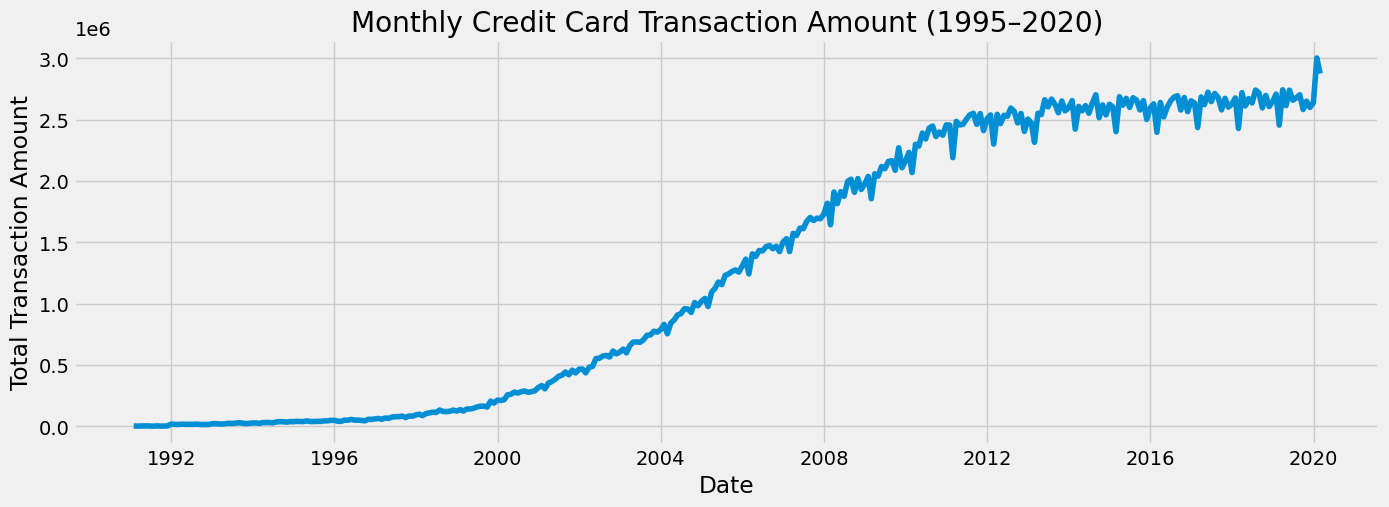

In [15]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(monthly_txn)
plt.title('Monthly Credit Card Transaction Amount (1995–2020)')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')

In [16]:
# Check Tail end of Data

monthly_txn.tail()

txn_date
2019-10-31    2651103.57
2019-11-30    2599894.32
2019-12-31    2639955.09
2020-01-31    3003022.88
2020-02-29    2876337.85
Freq: ME, Name: txn_amount, dtype: float64

In [17]:
# Get the last index (date) in the dataframe

last_date = monthly_txn.index.max()
print("txn_date:", last_date)

txn_date: 2020-02-29 00:00:00


In [18]:
# Check for missing values

monthly_txn.isnull().sum()

0

In [19]:
# Check for Duplicates

dups = monthly_txn.duplicated()
dups.sum()

0

# 04. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(monthly_txn, model='additive')

In [21]:
# This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

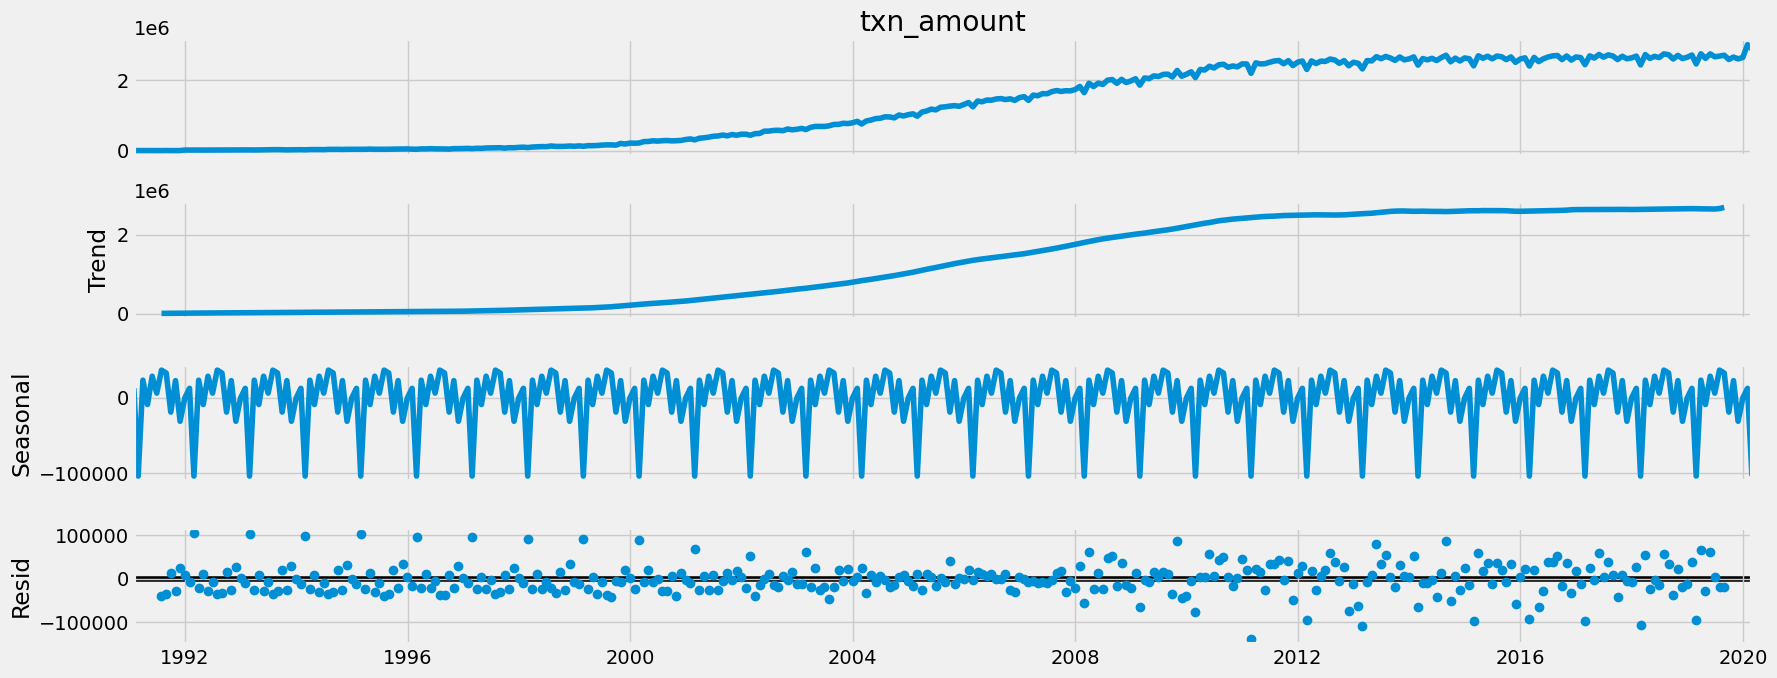

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

Trend: The long term trend is increasing thoughout the data set. Upward Trend

Seasonal: The seasonal trend is clear here. Up and slowly goes down until it goes back to it;s low peak and spikes.

Residual: The residual is tighter in the 1990's and early 2000's and after 2008 the residual noise increases. This implies more irregular fluctuations or unusual spending events as compared to previous years.


# 05. Testing Stationarity

In [24]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_txn)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.034711
p-value                          0.955566
Number of Lags Used             15.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


Dickey-Fuller Test Interpretation

Null hypothesis: The time series is non-stationary (it has a unit root).

Alternative hypothesis: The time series is stationary (no unit root).

The test statistic is much higher than all critical values, and the p-value is above 0.05.
Therefore we fail to reject the null hypothesis.

The monthly credit card transaction series is non-stationary, meaning it shows a trend or changing variance over time. Before modeling or forcasting more transformations are needed to make it stationary.

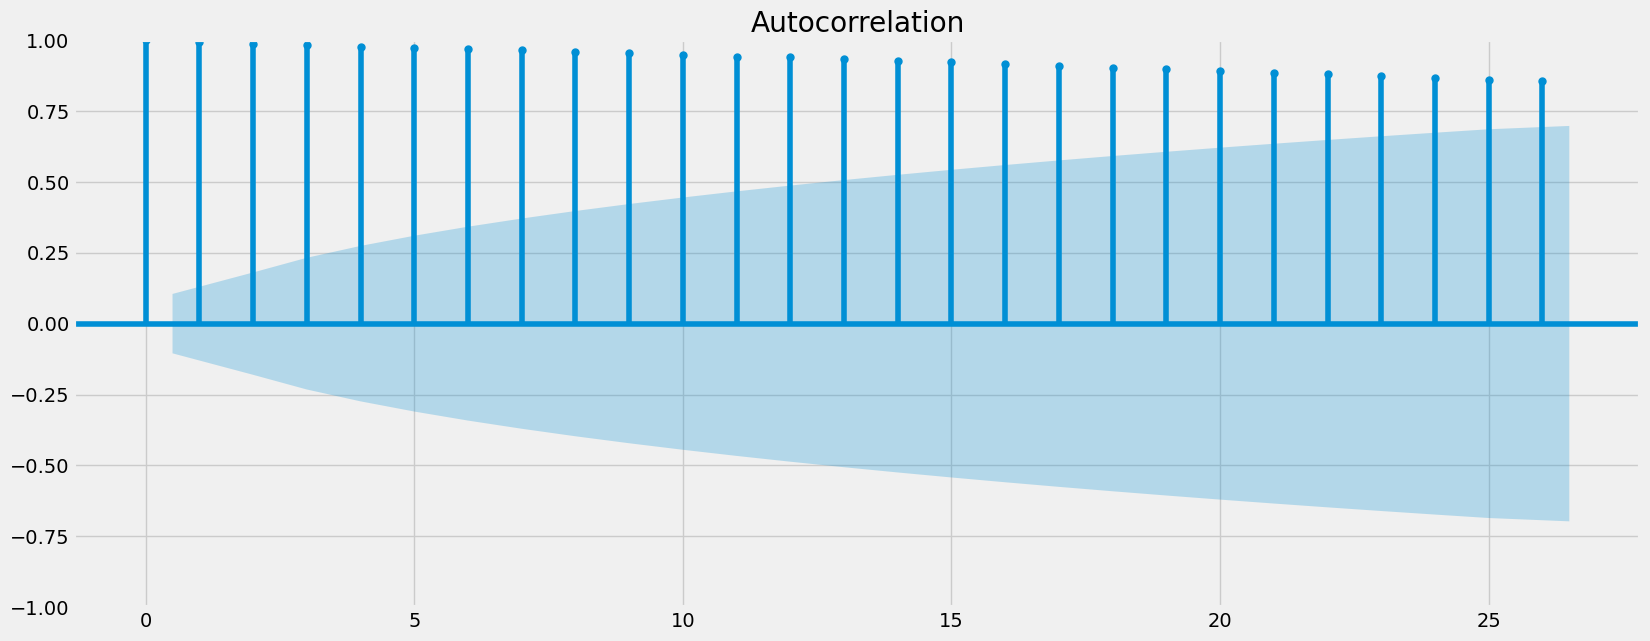

In [25]:
# Check out a plot of autocorrelations

plot_acf(monthly_txn)
plt.show()

# 06. Stationarizing the CC Data

### 1st Order Differencing

In [26]:
monthly_txn_diff = monthly_txn.diff().dropna()

In [27]:
print(monthly_txn_diff.head())

txn_date
1991-02-28    -925.35
1991-03-31     565.05
1991-04-30     -53.05
1991-05-31    1241.14
1991-06-30   -1283.37
Freq: ME, Name: txn_amount, dtype: float64


Text(0, 0.5, 'Change in Transaction Amount')

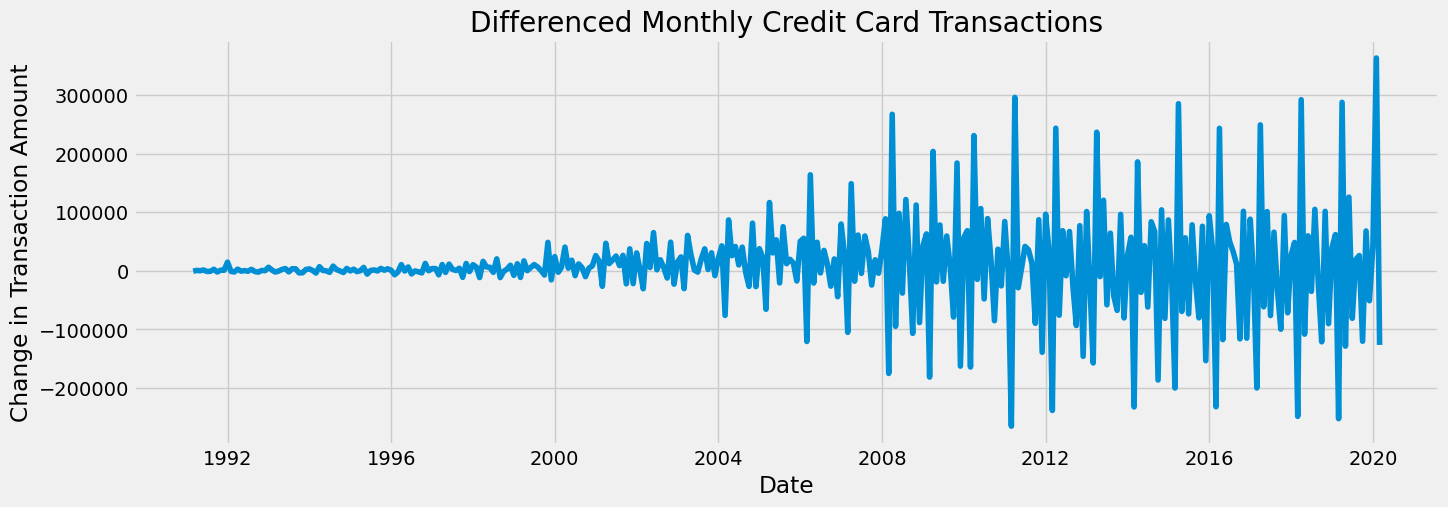

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(monthly_txn_diff)
plt.title('Differenced Monthly Credit Card Transactions')
plt.xlabel('Date')
plt.ylabel('Change in Transaction Amount')

In [30]:
dickey_fuller(monthly_txn_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.824700
p-value                          0.368270
Number of Lags Used             14.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


Dickey-Fuller Test Interpretation

Null hypothesis: The time series is non-stationary (it has a unit root).

Alternative hypothesis: The time series is stationary (no unit root).

The test statistic is still higher than all critical values, and the p-value is above 0.05. Therefore we fail to reject the null hypothesis.

The monthly credit card transaction series is non-stationary, meaning it shows a trend or changing variance over time. Before modeling or forcasting more transformations are needed to make it stationary.

### Log-Differencing

Will do a log transformation to stabalize variance as credit card totals grow over time, increasing the variance. This might also help avoid over differencing to avoid hiding seasonal patterns.

In [35]:
# Log transform (avoid log(0) by adding a small constant if needed)

monthly_txn_log = np.log(monthly_txn + 1)

In [36]:
# First-order differencing on log-transformed series

monthly_txn_log_diff = monthly_txn_log.diff().dropna()

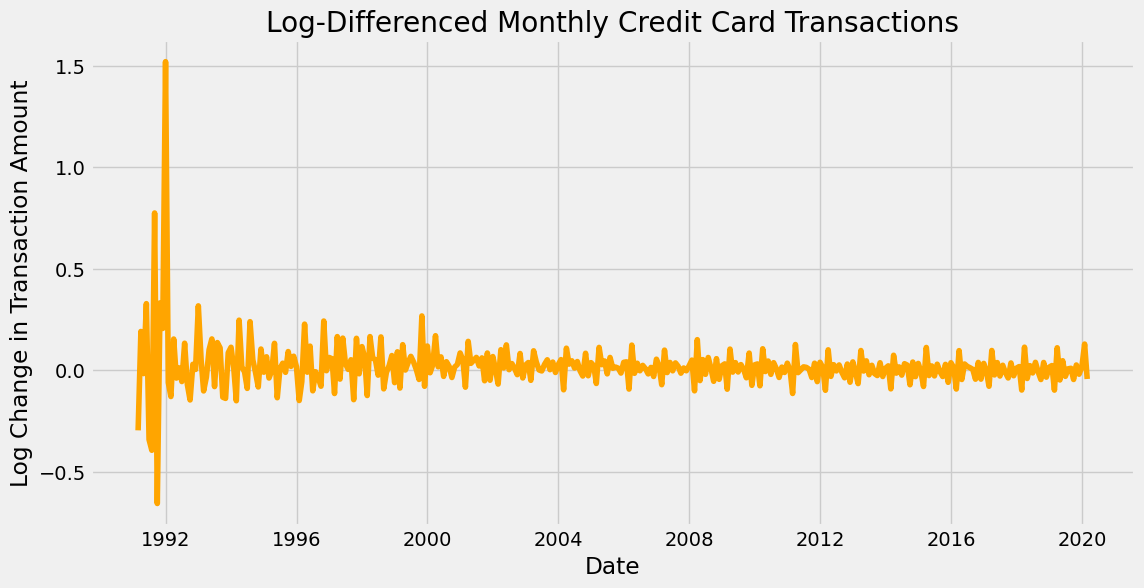

In [37]:
# Plot

plt.figure(figsize=(12,6))
plt.plot(monthly_txn_log_diff, color='orange')
plt.title('Log-Differenced Monthly Credit Card Transactions')
plt.xlabel('Date')
plt.ylabel('Log Change in Transaction Amount')
plt.show()

In [38]:
# Dickey-Fuller test

dickey_fuller(monthly_txn_log_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.573280e+00
p-value                        2.258196e-16
Number of Lags Used            1.200000e+01
Number of Observations Used    3.360000e+02
Critical Value (1%)           -3.449963e+00
Critical Value (5%)           -2.870181e+00
Critical Value (10%)          -2.571373e+00
dtype: float64


Dickey-Fuller Test Interpretation

Null hypothesis: The time series is non-stationary (it has a unit root).

Alternative hypothesis: The time series is stationary (no unit root).

The test statistic is much lower than all critical values, and the p-value is far below 0.05. Therefore we reject the null hypothesis, concluding the series is stationary.

The log-differenced  monthly credit card transaction series has constant mean and variance, making it suitable for decomposition, modeling, and forecasting.

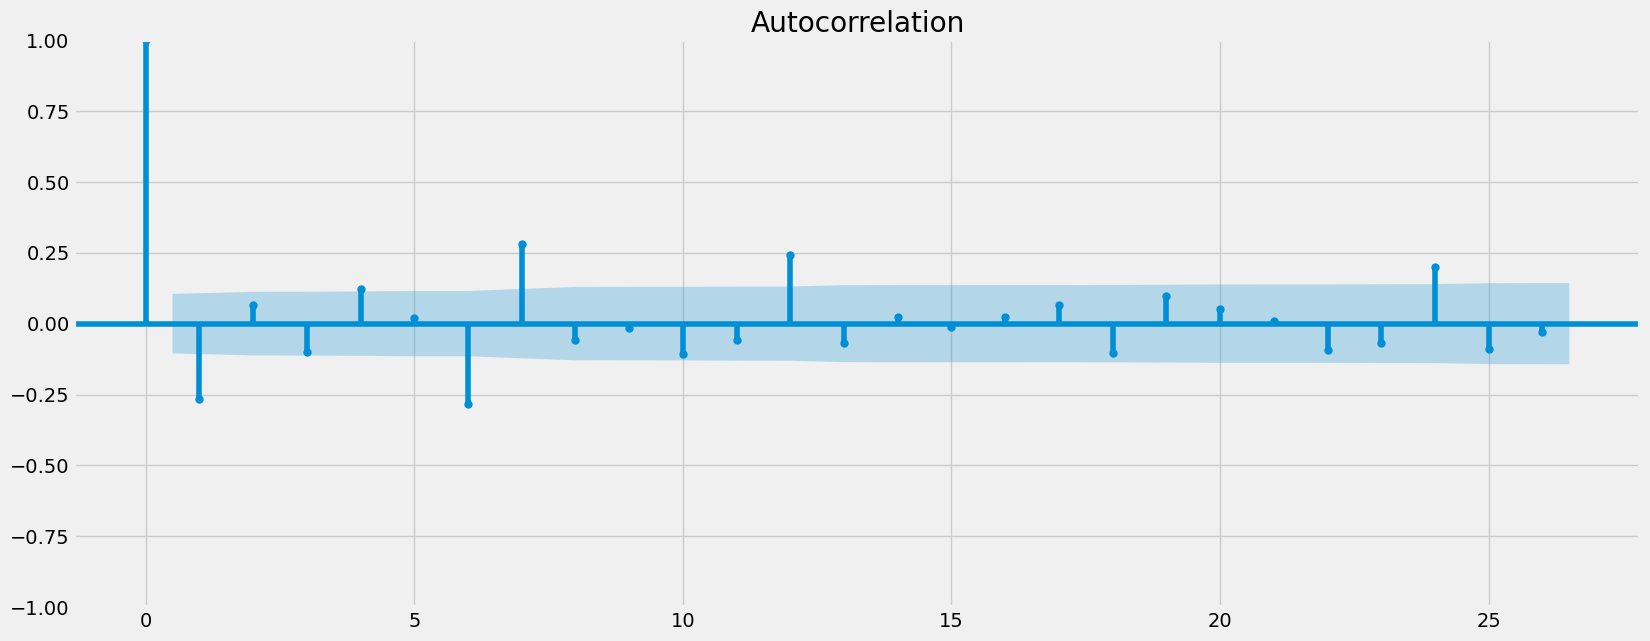

In [39]:
plot_acf(monthly_txn_log_diff)
plt.show()